### _Reward extraction: Experiment 1_
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Reward extraction using C3D network and KTH dataset <br>


In [ ]:
## Imports
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, MaxPooling2D, Input, Concatenate,MaxPooling3D, Reshape, ZeroPadding3D
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
import pylab as plt
import keras
import keras.backend as K

## Custom scripts
import lscript as lsp
import dataset as dset
import modelling as md

In [ ]:
## Defining variables
time_step=50 # Sequence length
imagefolderpath= ('/nobackup/leopauly/KTH_new/') # Folder path where the video sequences are stored
print(os.path.isdir(imagefolderpath)) # Checking if directory of video dataset exists
LOG_DIR='./logdir'
custom_global_step=0
nb_classes=3
lr_rate=.0005
batch_size = 5
height=150
width=300
channel=1
lstm_h_units=10
cluster_length=2
num_clusters=25
feature_size=487
extraction_batch_size=1

#### Preparing the pretrained model

In [3]:
## Defining placeholders in tf
data = tf.placeholder(tf.float32, [None, cluster_length, height, width, channel]) #step_size=No: of frames in video sequence
target = tf.placeholder(tf.float32, [None, nb_classes])

In [4]:
## Suggested Network structure: Conv3D followed by LSTM
model=md.modelC3D(cluster_length, height, width, channel, load_weights=False)
feature_out=model([data])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 150, 300, 1)    0         
_________________________________________________________________
conv1 (Conv3D)               (None, 2, 150, 300, 64)   1792      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 2, 75, 150, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 2, 75, 150, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 1, 37, 75, 128)    0         
_________________________________________________________________
flatten (Flatten)            (None, 355200)            0         
_________________________________________________________________
fc8 (Dense)                  (None, 487)               172982887 
Total para

#### Extracting features 

In [5]:
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

In [6]:
## Splitting into clusters the video of source demonstration
x_demo,y_demo=dset.batch_gen_train(nb_classes,extraction_batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x_demo_original=x_demo
x_demo =x_demo.reshape(x_demo.shape[0],x_demo.shape[1],height,width,channel)
clusters_demo=dset.cluster_generator(x_demo,num_clusters,cluster_length,height,width,channel)

## Extraction of features
print('shape of clustered demo data:',clusters_demo.shape)
features_demo=np.zeros([num_clusters,feature_size])
for i in range(num_clusters):
    t=clusters_demo[i].reshape(1,cluster_length,height,width,channel)
    features_demo[i]= sess.run(feature_out,feed_dict={data:t})
    #print(features)
print('shape of features from robot actions: ',features_demo.shape)

(25, 2, 150, 300, 1)
shape of clustered demo data: (25, 2, 150, 300, 1)
shape of features from robot actions:  (25, 487)


In [7]:
## Splitting into & displaying clusters of target actions
x_robo,y_robo=dset.batch_gen_train(nb_classes,extraction_batch_size,time_step,height,width,channel,imagefolderpath,gray=True)
x_robo_original=x_robo
x_robo =x_robo.reshape(x_robo.shape[0],x_robo.shape[1],height,width,channel)
clusters_robo=dset.cluster_generator(x_robo,num_clusters,cluster_length,height,width,channel)

## Extracting features
print('shape of clustered robot data:',clusters_robo.shape)
features_robo=np.zeros([num_clusters,feature_size])
for i in range(num_clusters):
    t=clusters_robo[i].reshape(1,cluster_length,height,width,channel)
    features_robo[i]= sess.run(feature_out,feed_dict={data:t})
    #print(features)
print('shape of features from robot actions: ', features_robo.shape)

(25, 2, 150, 300, 1)
shape of clustered robot data: (25, 2, 150, 300, 1)
shape of features from robot actions:  (25, 487)


#### Extracting reward function

In [8]:
distance=np.ones([num_clusters,feature_size])
reward=np.ones([num_clusters,1])
for i in range(num_clusters):
    distance[i] = features_demo[i]-features_robo[i]
    reward[i]=-(np.linalg.norm(distance[i]))
#print(reward)
#print(dist)

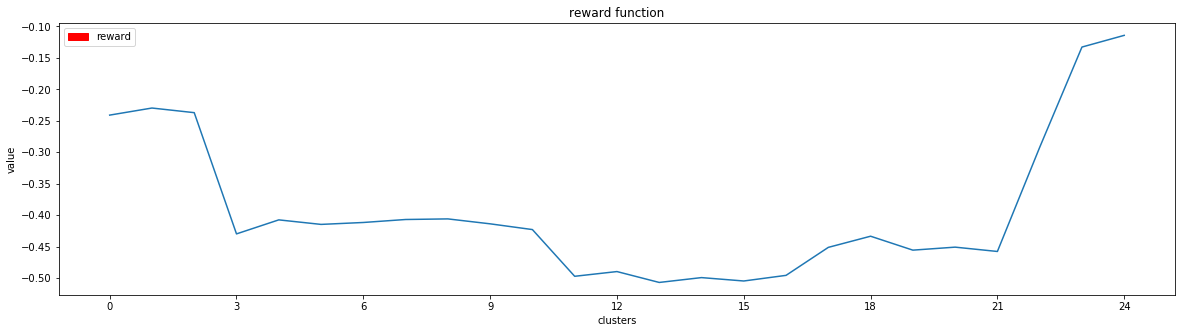

In [9]:
y_vlaues=list((range(num_clusters)))
lsp.plot_values_with_legends(y_vlaues,reward,'reward','clusters','value','reward function',color='red')

#### Displaying clusters

label:2.0
Video_seq shape: (25, 2, 150, 300) Label shape (25,)


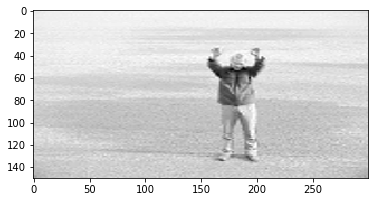

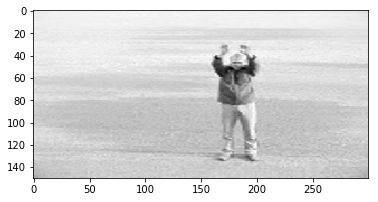

In [10]:
cluster_id=8
## Clusters from demos
y_d=np.repeat(y_demo,num_clusters) 
display=clusters_demo.reshape(clusters_demo.shape[0],clusters_demo.shape[1],clusters_demo.shape[2],clusters_demo.shape[3])
lsp.view_video_seq(display,y_d,cluster_length,cluster_id)

label:1.0
Video_seq shape: (25, 2, 150, 300) Label shape (25,)


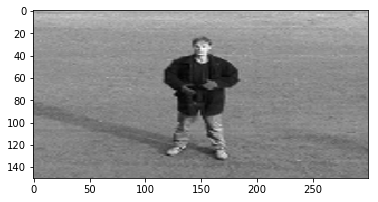

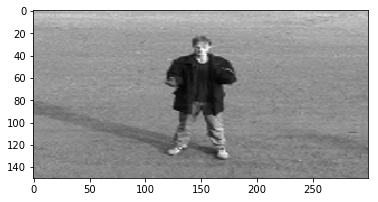

In [11]:
# Clusters from robot action
y_r=np.repeat(y_robo,num_clusters) 
display=clusters_robo.reshape(clusters_robo.shape[0],clusters_robo.shape[1],clusters_robo.shape[2],clusters_robo.shape[3])
lsp.view_video_seq(display,y_r,cluster_length,cluster_id)

#### Demonstrations / Source Video

label:2.0
Video_seq shape: (1, 50, 150, 300) Label shape (1,)


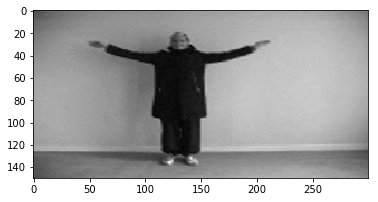

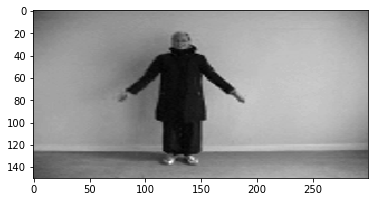

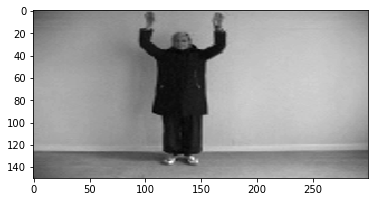

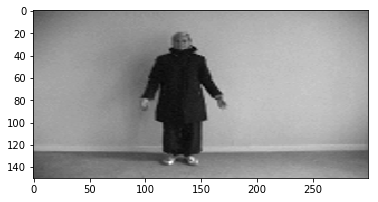

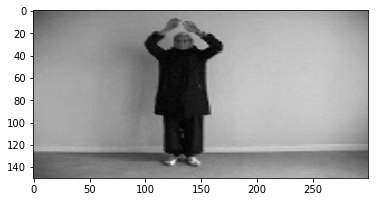

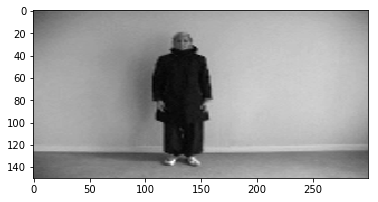

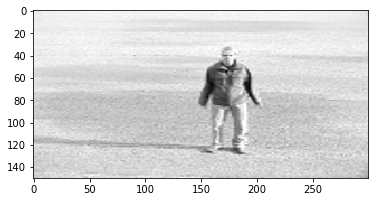

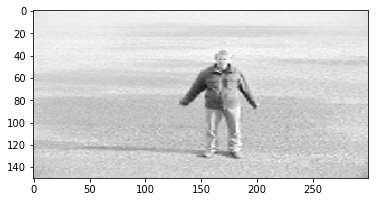

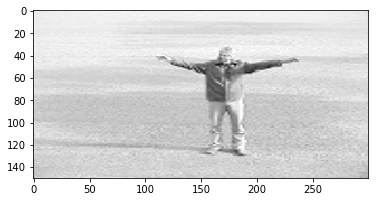

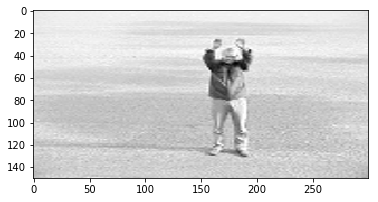

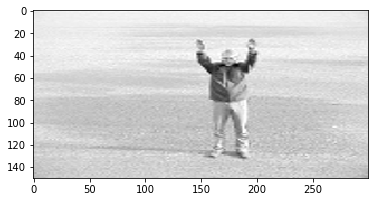

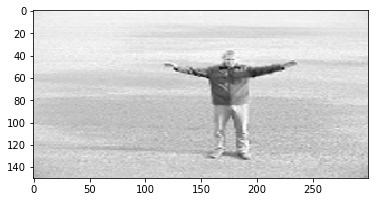

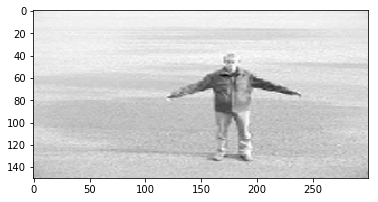

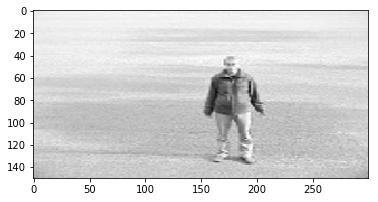

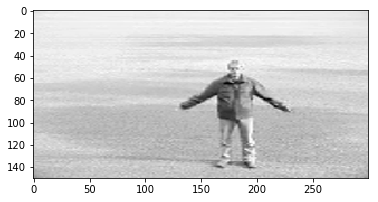

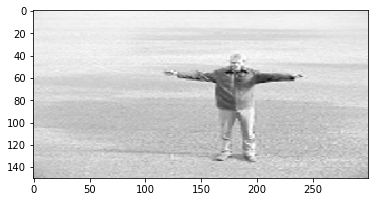

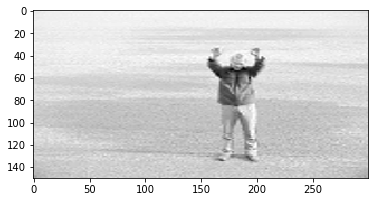

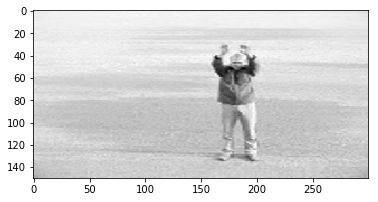

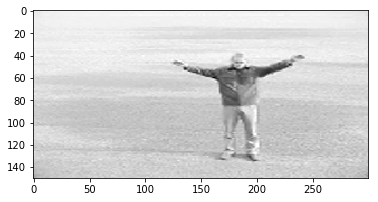

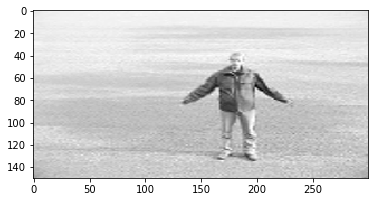

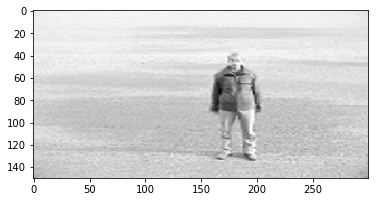

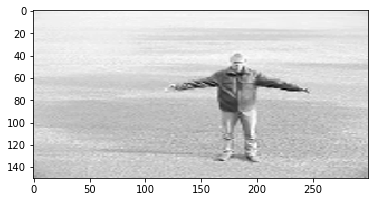

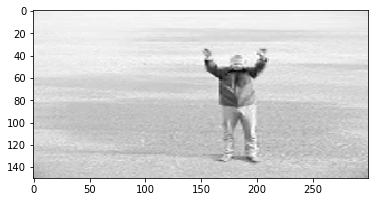

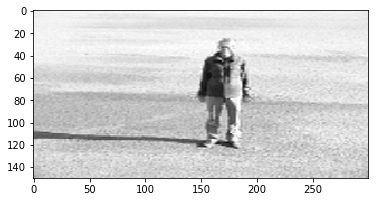

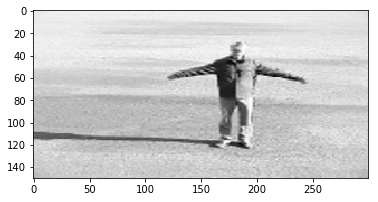

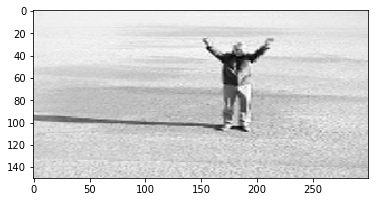

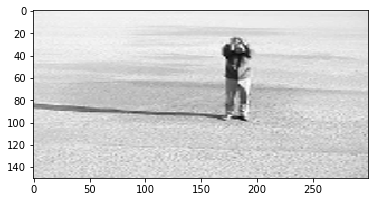

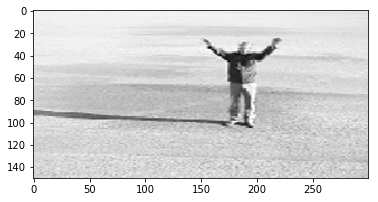

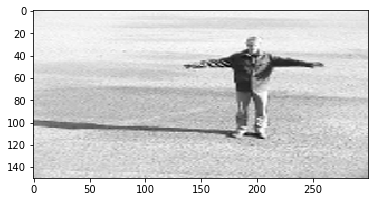

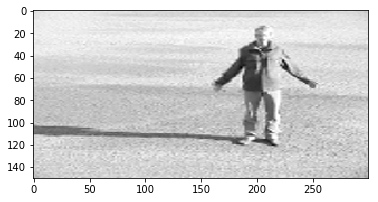

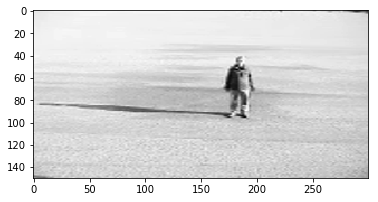

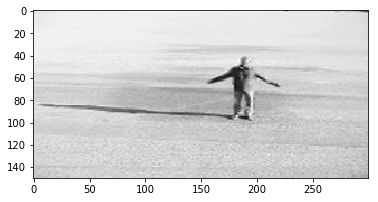

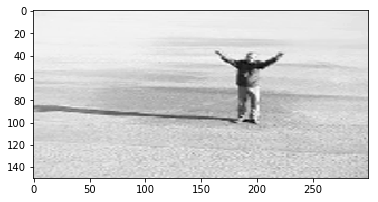

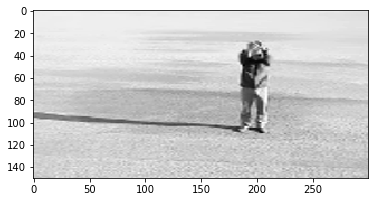

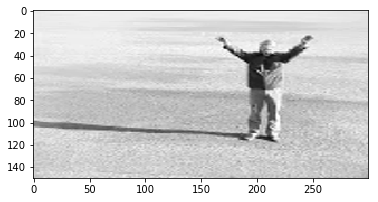

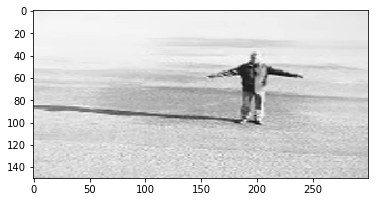

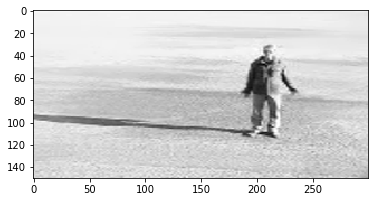

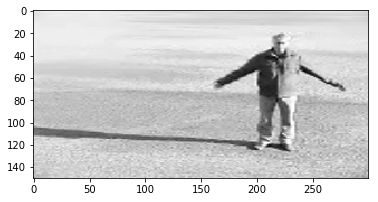

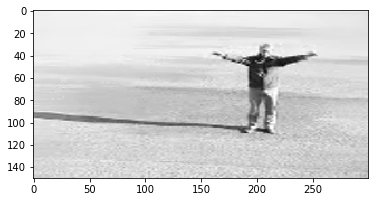

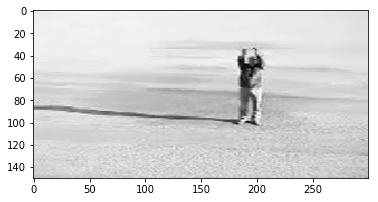

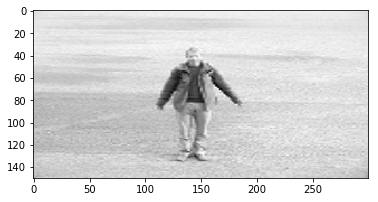

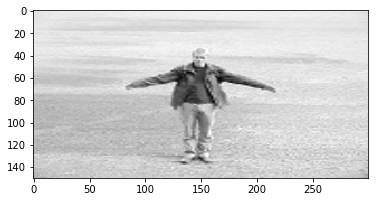

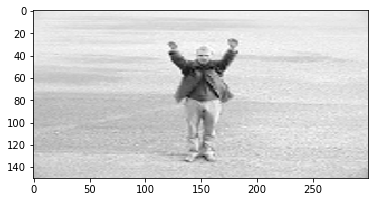

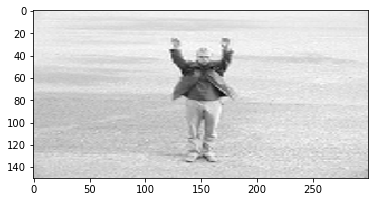

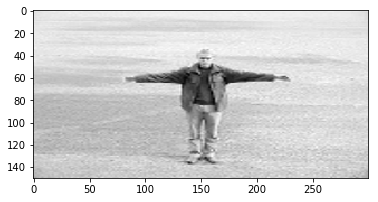

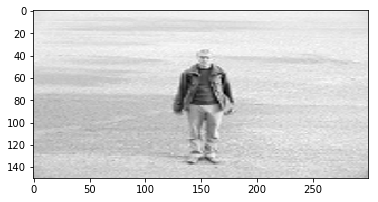

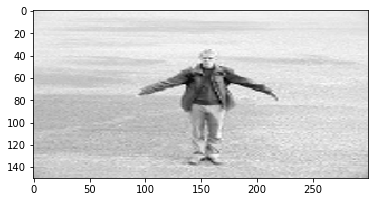

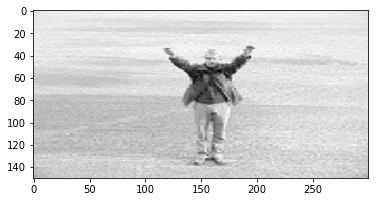

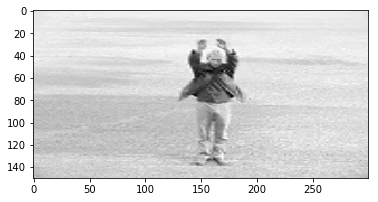

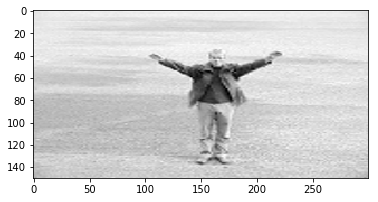

In [12]:
lsp.view_video_seq(x_demo_original,y_demo,time_step,0)

#### Robot / Target actions Video

label:1.0
Video_seq shape: (1, 50, 150, 300) Label shape (1,)


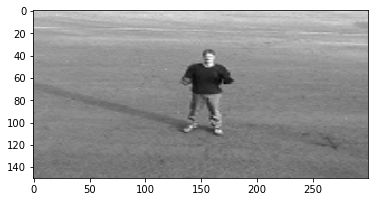

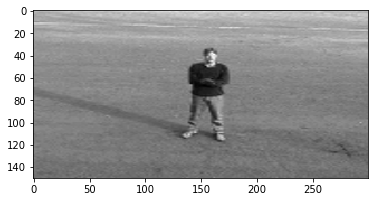

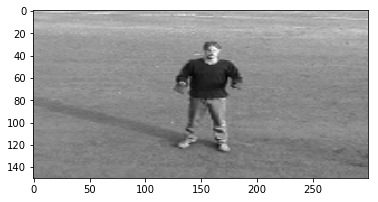

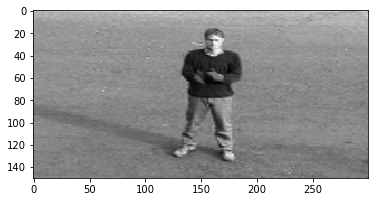

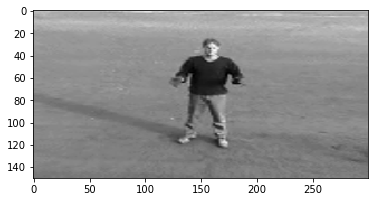

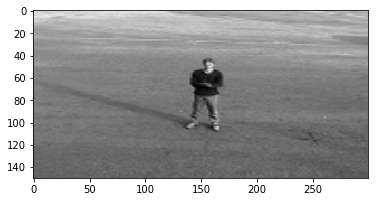

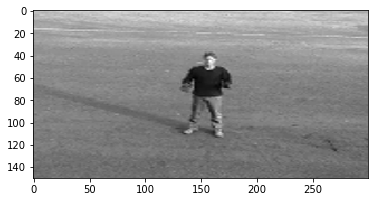

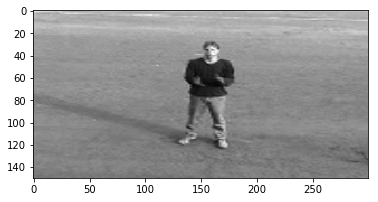

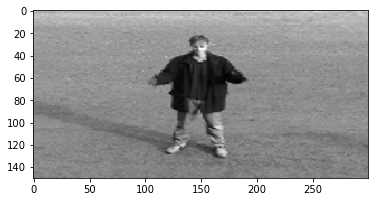

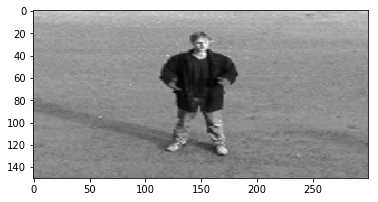

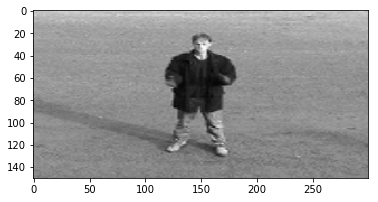

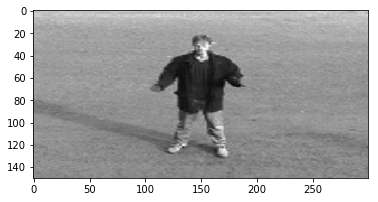

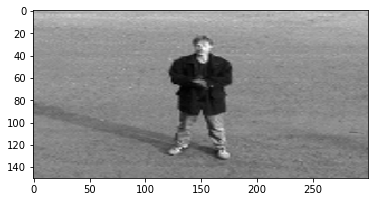

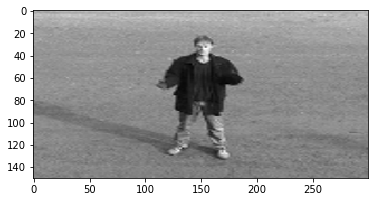

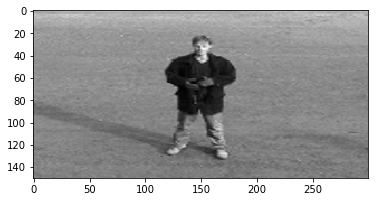

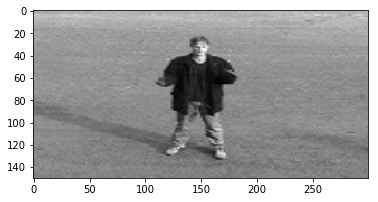

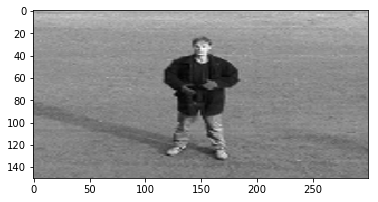

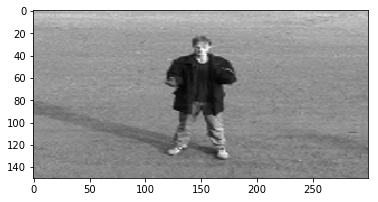

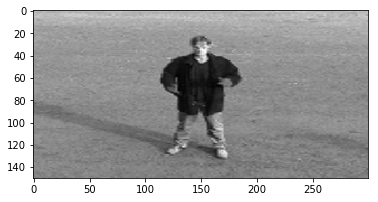

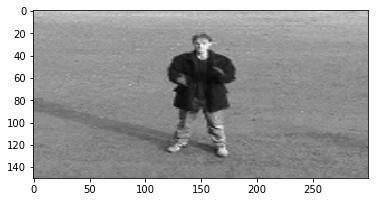

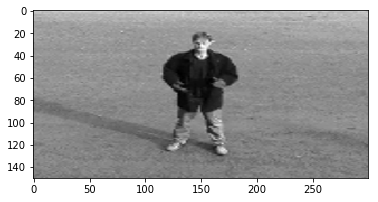

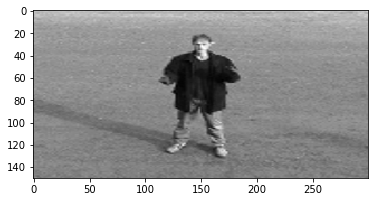

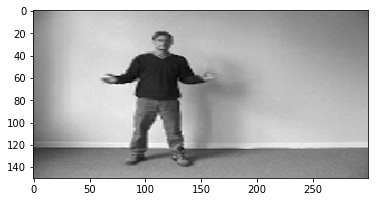

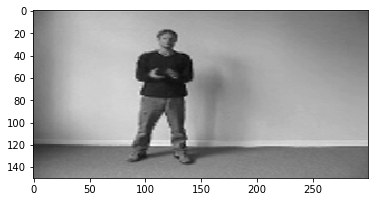

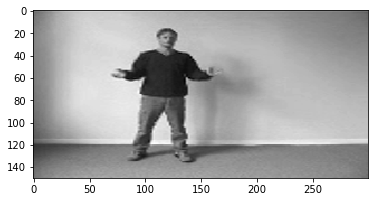

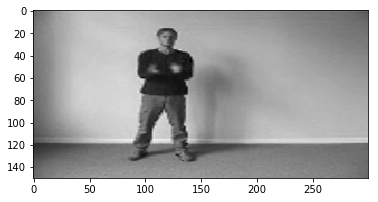

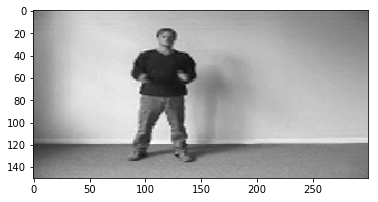

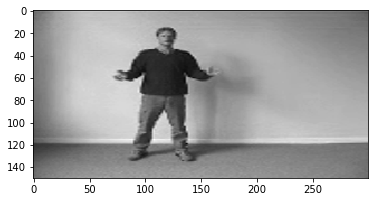

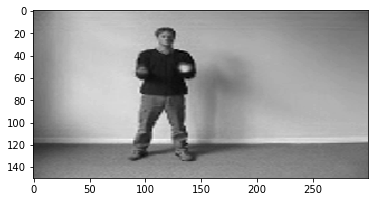

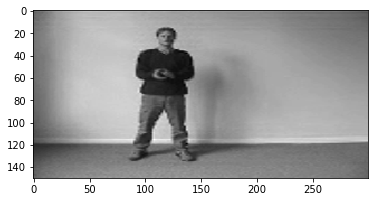

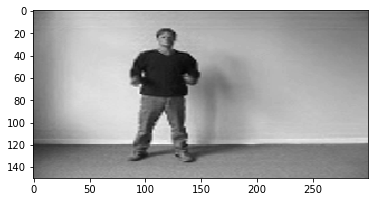

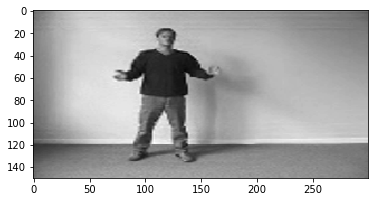

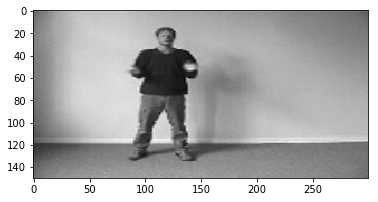

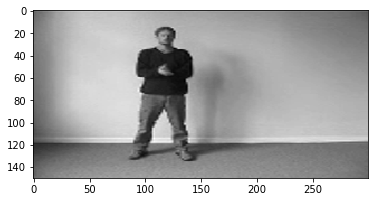

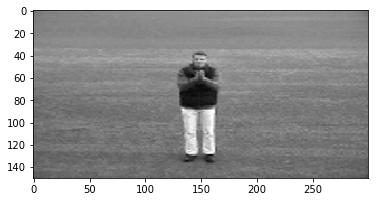

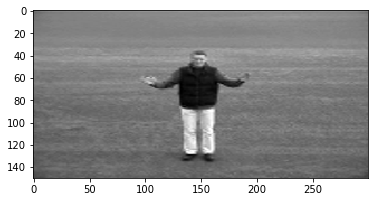

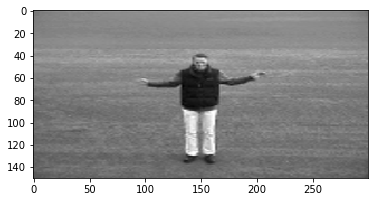

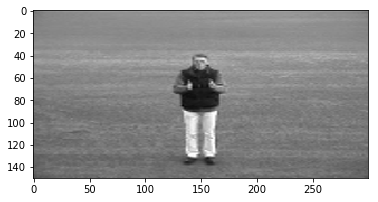

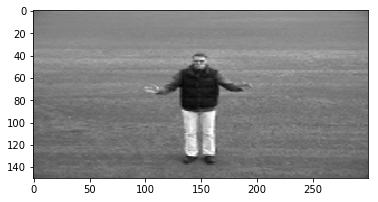

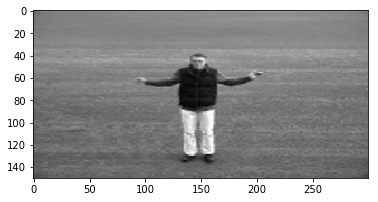

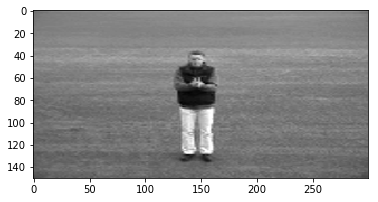

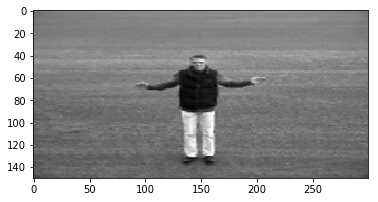

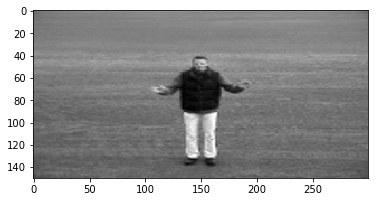

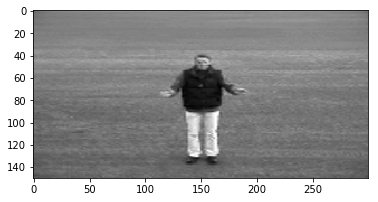

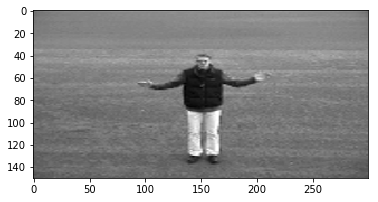

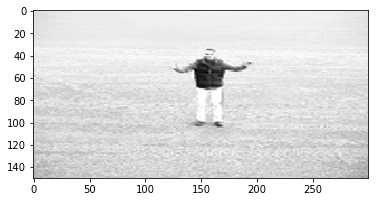

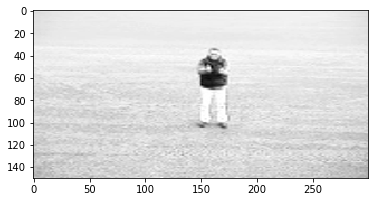

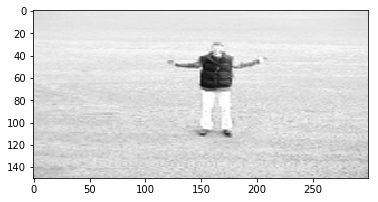

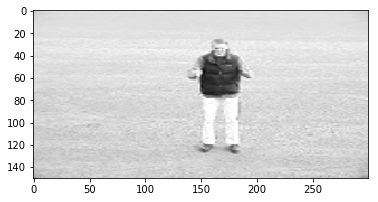

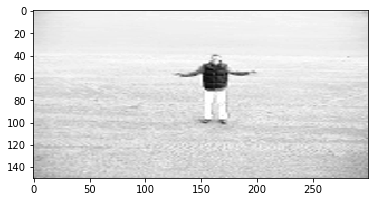

In [13]:
lsp.view_video_seq(x_robo_original,y_robo,time_step,0)

In [14]:
#sess.close()